# Data exploration


In [ ]:
import numpy as np
import matplotlib.pylab as plt
import IPython.display as ipd
import os
import torch
from audiosep.io import load_audio_tensor
from collections import Counter


In [5]:
idx = 1
root = "../data/train_small/"

example_dirs = sorted(
    d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))
)

print(f"Nombre d'exemples dans le jeu de données : {len(example_dirs)}")

folder = example_dirs[idx]
folder_path = os.path.join(root, folder)

# filenames
mix_file = [f for f in os.listdir(folder_path) if f.startswith("mix")][0]
mix_path = os.path.join(folder_path, mix_file)
voice_path = os.path.join(folder_path, "voice.wav")
noise_path = os.path.join(folder_path, "noise.wav")

mix, sr_mix = load_audio_tensor(mix_path)
voice, sr_voice = load_audio_tensor(voice_path)
noise, sr_noise = load_audio_tensor(noise_path)

# Normalize mix to have same peak as voice
eps = 1e-12
voice_peak = torch.max(torch.abs(voice)) + eps
mix_peak = torch.max(torch.abs(mix)) + eps
mix = mix * (voice_peak / mix_peak)

# Listen to each signal in the notebook
print(f"Mix {mix_file}:")
ipd.display(ipd.Audio(mix, rate=sr_mix))
print(f"Voice {voice_path}:")
ipd.display(ipd.Audio(voice, rate=sr_voice))
print(f"Noise {noise_path}:")
ipd.display(ipd.Audio(noise, rate=sr_noise))

Nombre d'exemples dans le jeu de données : 50
Mix mix_snr_0.wav:


Voice ../data/train_small/0001\voice.wav:


Noise ../data/train_small/0001\noise.wav:


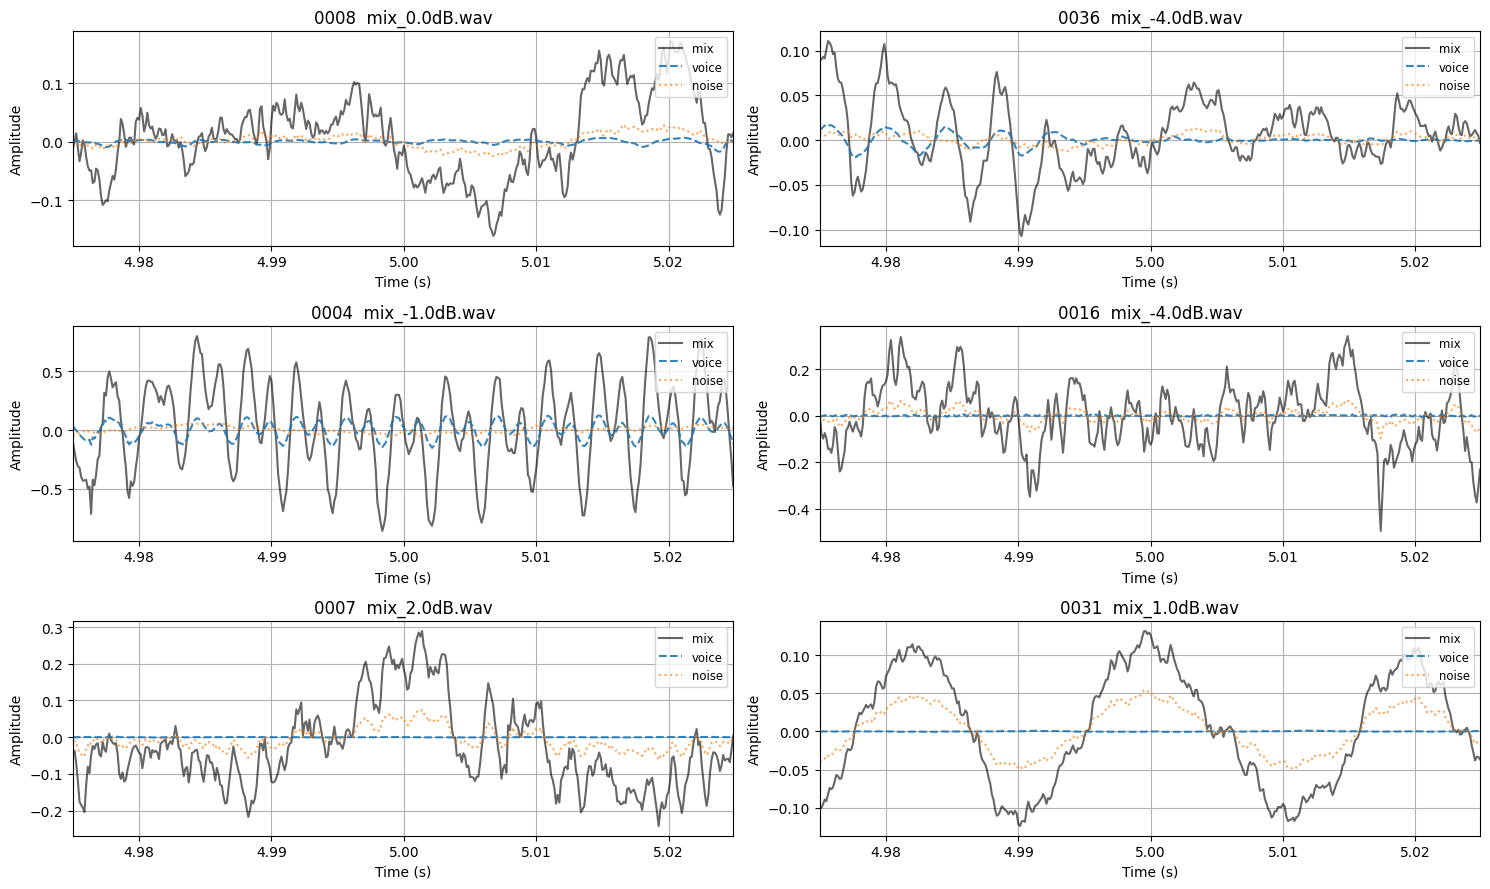

In [6]:
import os
import random
import re
import numpy as np
import matplotlib.pyplot as plt
from audiosep.io import load_audio_tensor
import torch

root = "../data/train_small/"
n_plots = 6
win_sec = 0.05  # window length in seconds to plot

example_dirs = sorted(
    d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))
)
if len(example_dirs) < n_plots:
    raise RuntimeError("Not enough examples in dataset")

random.seed(1)
sel = random.sample(example_dirs, n_plots)


def _extract_snr_label(filename: str) -> str:
    m = re.search(r"(-?\d+(?:\.\d+)?)\s*[dD][bB]", filename)
    if m:
        return f"{float(m.group(1)):.1f}dB"
    m2 = re.search(r"(?:(?:^|[_\-\.\s]))(-?\d+(?:\.\d+)?)(?=$|[_\-\.\s])", filename)
    if m2:
        return f"{float(m2.group(1)):.1f}dB"
    return "n/a"


def _load_numpy(path):
    sig, sr = load_audio_tensor(path)
    # support torch tensor or numpy array, ensure 1D numpy
    if isinstance(sig, torch.Tensor):
        sig = sig.detach().cpu().numpy()
    sig = np.asarray(sig)
    if sig.ndim > 1:
        sig = sig[0]
    return sig, sr


# Preload data (one IO per file)
items = []
for folder in sel:
    fp = os.path.join(root, folder)
    mix_file = [f for f in os.listdir(fp) if f.startswith("mix")][0]
    mix_path = os.path.join(fp, mix_file)
    voice_path = os.path.join(fp, "voice.wav")
    noise_path = os.path.join(fp, "noise.wav")
    mix, sr_mix = _load_numpy(mix_path)
    voice, _ = _load_numpy(voice_path)
    noise, _ = _load_numpy(noise_path)
    items.append((folder, mix_file, mix, voice, noise, sr_mix))

# Plot grid
rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(15, 9))
axes = axes.ravel()

for ax, (folder, mix_file, mix, voice, noise, sr_mix) in zip(axes, items):
    # align lengths
    min_len = min(len(mix), len(voice), len(noise))
    mix = mix[:min_len]
    voice = voice[:min_len]
    noise = noise[:min_len]

    # normalize
    # mix = mix / (np.max(np.abs(mix)) + eps)
    # voice = voice / (np.max(np.abs(voice)) + eps)
    # noise = noise / (np.max(np.abs(noise)) + eps)

    # def rms(x):
    #     return np.sqrt(np.mean(x**2) + eps)

    # mix = mix / rms(mix)
    # voice = voice / rms(voice)
    # noise = noise / rms(noise)

    # Normalisation
    # mix = mix / (np.max(np.abs(mix)) + eps)
    # voice = voice / (np.max(np.abs(voice)) + eps)
    # noise = noise / (np.max(np.abs(noise)) + eps)

    # normalize by mix peak (preserves mix = voice + noise)
    gain = 1.0 / (np.abs(mix).max() + 1e-8)
    mix = mix * gain
    voice = voice * gain
    noise = noise * gain

    # snr label from filename
    snr_label = _extract_snr_label(mix_file)
    if snr_label == "n/a":
        # fallback compute
        voice_power = np.mean(voice.astype(np.float64) ** 2)
        noise_power = np.mean(noise.astype(np.float64) ** 2)
        if noise_power <= eps:
            snr_label = "inf"
        else:
            snr_db = 10.0 * np.log10((voice_power + eps) / (noise_power + eps))
            snr_label = f"{snr_db:.1f}dB"

    # choose central window
    win_len = min(int(win_sec * sr_mix), min_len)
    start = max(0, (min_len - win_len) // 2)
    end = start + win_len
    t = np.arange(win_len) / sr_mix + start / sr_mix

    ax.plot(t, mix[start:end], label="mix", color="k", alpha=0.6)
    ax.plot(t, voice[start:end], label="voice", linestyle="--", alpha=0.9)
    ax.plot(t, noise[start:end], label="noise", linestyle=":", alpha=0.7)
    ax.set_title(f"{folder}  mix_{snr_label}.wav")
    ax.set_xlim(t[0], t[-1])
    # ax.set_ylim(-0.25, 0.25)
    ax.grid(True)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.legend(loc="upper right", fontsize="small")

plt.tight_layout()
plt.show()

In [ ]:
root = "../data/train_small/"
eps = 1e-12


def _to_mono_np(sig):
    if isinstance(sig, torch.Tensor):
        sig = sig.detach().cpu().numpy()
    sig = np.asarray(sig, dtype=np.float32)
    # librosa mono=False => (C,T) ou (T,)
    if sig.ndim == 2:
        sig = sig.mean(axis=0)
    elif sig.ndim > 2:
        sig = sig.reshape(-1, sig.shape[-1]).mean(axis=0)
    return sig


def load_mono(path, target_sr=None):
    sig, sr = load_audio_tensor(path, target_sample_rate=target_sr)
    return sig.detach().cpu().numpy(), sr


def rms(x):
    x = x.astype(np.float64)
    return float(np.sqrt(np.mean(x * x) + eps))


def snr_db(voice, noise):
    vp = np.mean(voice.astype(np.float64) ** 2) + eps
    npow = np.mean(noise.astype(np.float64) ** 2) + eps
    return float(10.0 * np.log10(vp / npow))


def parse_snr_from_filename(name):
    m = re.search(r"(-?\d+(?:\.\d+)?)\s*[dD][bB]", name)
    return float(m.group(1)) if m else None


def moving_rms(x, win, hop):
    x2 = x.astype(np.float64) ** 2
    if len(x2) < win:
        return np.array([], dtype=np.float64)
    kernel = np.ones(win, dtype=np.float64) / win
    y = np.convolve(x2, kernel, mode="valid")
    return np.sqrt(y[::hop] + eps)


In [ ]:
example_dirs = sorted(
    d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))
)
print("N exemples:", len(example_dirs))

rows = []
sr_counter = Counter()
bad = []

for folder in example_dirs:
    fp = os.path.join(root, folder)
    mix_files = sorted(
        [
            f
            for f in os.listdir(fp)
            if f.lower().startswith("mix") and f.lower().endswith(".wav")
        ]
    )
    if not mix_files:
        bad.append((folder, "no mix wav"))
        continue

    mix_file = mix_files[0]
    mix_path = os.path.join(fp, mix_file)
    voice_path = os.path.join(fp, "voice.wav")
    noise_path = os.path.join(fp, "noise.wav")
    if not (os.path.exists(voice_path) and os.path.exists(noise_path)):
        bad.append((folder, "missing voice/noise"))
        continue

    mix, sr = load_mono(mix_path)
    voice, _ = load_mono(voice_path, target_sr=sr)
    noise, _ = load_mono(noise_path, target_sr=sr)
    sr_counter[sr] += 1

    L = min(len(mix), len(voice), len(noise))
    mix, voice, noise = mix[:L], voice[:L], noise[:L]
    dur = L / float(sr)

    # Sanity check: mix ≈ voice + noise
    rel_mix_err = rms(mix - (voice + noise)) / (rms(mix) + eps)

    snr_true = snr_db(voice, noise)
    snr_name = parse_snr_from_filename(mix_file)

    clip = lambda x: float(np.mean(np.abs(x) >= 0.999))
    silence_thr = 1e-4
    silence_mix = float(np.mean(np.abs(mix) <= silence_thr))

    # proxy difficulté: overlap (frames où voice & noise actifs)
    win = int(0.020 * sr)  # 20ms
    hop = int(0.010 * sr)  # 10ms
    env_v = moving_rms(voice, win, hop)
    env_n = moving_rms(noise, win, hop)
    if len(env_v) and len(env_n):
        thr_v = 0.05 * float(env_v.max() + eps)
        thr_n = 0.05 * float(env_n.max() + eps)
        v_act = env_v > thr_v
        n_act = env_n > thr_n
        overlap = float(np.mean(v_act & n_act))
        voice_only = float(np.mean(v_act & ~n_act))
        noise_only = float(np.mean(~v_act & n_act))
    else:
        overlap = np.nan
        voice_only = np.nan
        noise_only = np.nan

    rows.append(
        dict(
            folder=folder,
            mix_file=mix_file,
            sr=sr,
            duration_s=dur,
            n_samples=L,
            snr_db=snr_true,
            snr_db_name=snr_name,
            rms_mix=rms(mix),
            rms_voice=rms(voice),
            rms_noise=rms(noise),
            peak_mix=float(np.max(np.abs(mix))),
            rel_mix_err=rel_mix_err,
            clip_mix=clip(mix),
            clip_voice=clip(voice),
            clip_noise=clip(noise),
            silence_mix=silence_mix,
            overlap=overlap,
            voice_only=voice_only,
            noise_only=noise_only,
        )
    )

print("Exemples ok:", len(rows), "| problèmes:", len(bad))
if bad[:5]:
    print("Exemples problématiques (5 premiers):", bad[:5])


def describe(vals):
    x = np.asarray(
        [
            v
            for v in vals
            if v is not None and not (isinstance(v, float) and np.isnan(v))
        ],
        dtype=np.float64,
    )
    if x.size == 0:
        return {}
    return dict(
        n=int(x.size),
        mean=float(x.mean()),
        std=float(x.std()),
        p05=float(np.percentile(x, 5)),
        p50=float(np.percentile(x, 50)),
        p95=float(np.percentile(x, 95)),
        min=float(x.min()),
        max=float(x.max()),
    )


print("SR distribution:", dict(sr_counter))
print("Durations (s):", describe([r["duration_s"] for r in rows]))
print("SNR (dB):", describe([r["snr_db"] for r in rows]))
print("Rel mix error:", describe([r["rel_mix_err"] for r in rows]))
print("Overlap:", describe([r["overlap"] for r in rows]))
print("Peak mix:", describe([r["peak_mix"] for r in rows]))


N exemples: 50
Exemples ok: 50 | problèmes: 0
SR distribution: {8000: 50}
Durations (s): {'n': 50, 'mean': 0.000125, 'std': 0.0, 'p05': 0.000125, 'p50': 0.000125, 'p95': 0.000125, 'min': 0.000125, 'max': 0.000125}
SNR (dB): {'n': 50, 'mean': -3.318594387568885, 'std': 2.281747060560534, 'p05': -6.828253291771618, 'p50': -3.6056406413602424, 'p95': 0.1622212285250238, 'min': -8.083481729922726, 'max': 0.9736945553485123}
Rel mix error: {'n': 50, 'mean': 0.7781226328648504, 'std': 0.031951375777936705, 'p05': 0.7250570600161631, 'p50': 0.783050778377615, 'p95': 0.8236520737075504, 'min': 0.6879229921046407, 'max': 0.8419972146205303}
Overlap: {}
Peak mix: {'n': 50, 'mean': 0.3765956163406372, 'std': 0.06519834260083864, 'p05': 0.30458822250366213, 'p50': 0.36828866600990295, 'p95': 0.48148212432861326, 'min': 0.2691497504711151, 'max': 0.6067280173301697}


In [10]:
rows_sorted = sorted(rows, key=lambda r: r["snr_db"])
hard = rows_sorted[:8]
easy = rows_sorted[-8:]


def show_example(r):
    fp = os.path.join(root, r["folder"])
    mix_path = os.path.join(fp, r["mix_file"])
    voice_path = os.path.join(fp, "voice.wav")
    noise_path = os.path.join(fp, "noise.wav")

    mix, sr = load_mono(mix_path)
    voice, _ = load_mono(voice_path, target_sr=sr)
    noise, _ = load_mono(noise_path, target_sr=sr)
    L = min(len(mix), len(voice), len(noise))
    mix, voice, noise = mix[:L], voice[:L], noise[:L]

    print(
        f"{r['folder']} | {r['mix_file']} | dur={L / sr:.2f}s | snr={r['snr_db']:.1f}dB | overlap={r['overlap']:.2f} | rel_mix_err={r['rel_mix_err']:.3g}"
    )
    ipd.display(ipd.Audio(mix, rate=sr))
    ipd.display(ipd.Audio(voice, rate=sr))
    ipd.display(ipd.Audio(noise, rate=sr))


print("Hardest (lowest SNR):")
for r in hard[:3]:
    show_example(r)


Hardest (lowest SNR):
0031 | mix_snr_1.wav | dur=10.00s | snr=-8.1dB | overlap=0.40 | rel_mix_err=0.771


0035 | mix_snr_3.wav | dur=10.00s | snr=-7.0dB | overlap=0.47 | rel_mix_err=0.793


0025 | mix_snr_4.wav | dur=10.00s | snr=-6.9dB | overlap=0.42 | rel_mix_err=0.842
